Session 0.0: Load packages and customised functions

In [1]:
## a useful function to generate a data list for further analysis
import os,json,sys,itertools
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from locustvr_converter import preprocess_matrex_data
##need to add this additional cell because useful tools are in another folder. Need to integrate these two folders one day
current_working_directory = Path.cwd()
parent_dir = current_working_directory.resolve().parents[0]
sys.path.insert(0, str(parent_dir) + "\\utilities")
from useful_tools import select_animals_gpt,find_file
#from data_cleaning import preprocess_fictrac_data

In [2]:
import matplotlib as mpl
from matplotlib import cm
class MplColorHelper:
    def __init__(self, cmap_name, start_val, stop_val):
        self.cmap_name = cmap_name
        self.cmap = plt.get_cmap(cmap_name)
        self.norm = mpl.colors.Normalize(vmin=start_val, vmax=stop_val)
        self.scalarMap = cm.ScalarMappable(norm=self.norm, cmap=self.cmap)

    def get_rgb(self, val):
        return self.scalarMap.to_rgba(val)
colormap_name = "coolwarm"

Session 0.1: Load analysis methods in python dictionary form

In [3]:
json_file = "./analysis_methods_dictionary.json"
with open(json_file, "r") as f:
    analysis_methods = json.loads(f.read())
    

#Put the folder of your Unity experiment below
#thisDataset ="D:/MatrexVR_Swarm_Data/RunData"
thisDataset ="D:/MatrexVR_blackbackground_Data/RunData"
#thisDataset ="D:/MatrexVR_grass1_Data/RunData"

Session 0.2: Load animals' experiment directory into a list

In [10]:
## this cell searches for a folder with csv files, usually that is the folder saving the tracking data.
## Since data from the 4 VRs are saved in the same folder, this command will return that one folder for the 4 experiment
dir_list = []
file_type=".csv"
for root, dirs, files in os.walk(thisDataset):
    for folder in dirs:
        folder_path=os.path.join(root,folder)
        if any(name.endswith(file_type) for name in os.listdir(folder_path)):
            dir_list.append(folder_path.replace("\\", "/"))


print(f"these directories are found {dir_list}")

these directories are found ['D:/MatrexVR_grass1_Data/RunData/20240907_142802', 'D:/MatrexVR_grass1_Data/RunData/20240907_170446', 'D:/MatrexVR_grass1_Data/RunData/20240907_190839', 'D:/MatrexVR_grass1_Data/RunData/20240908_125638', 'D:/MatrexVR_grass1_Data/RunData/20240908_150715', 'D:/MatrexVR_grass1_Data/RunData/20240908_174232', 'D:/MatrexVR_grass1_Data/RunData/20240908_193840']


Session 1.0: Create curated dataset based on a list of experiment directories

In [ ]:
#This function receives directory path that contains the 4-VR data and save the tracking + stimulus information as h5 file
pattern="VR*.h5"
for this_dir in dir_list:
    if any(Path(this_dir).glob(pattern)) and analysis_methods.get("overwrite_curated_dataset")==False:
        print(f"curated matrexvr h5 database found in {this_dir}. Skip this file")
        continue
    else:
        print(f"no curated matrexvr h5 database in {this_dir}. Create curated file")
        preprocess_matrex_data(this_dir,analysis_methods)

Session 2.0: introduce customised plotting functions used in Sercan's paper

In [42]:
#introduce customised functions
def plot_sercansincos(df,parameters,parameter_name,vr_num='all'):
    
    cos = df["cos"]
    sin = df["sin"]
    if 'density' in df.columns:
        density=df["density"].unique()[0]
        cos_fig_name=f"{vr_num}_cos_{parameter_name}_{parameters}_density_{int(density)}.svg"
        sin_fig_name=f"{vr_num}_sin_{parameter_name}_{parameters}_density_{int(density)}.svg" 
    else:
        cos_fig_name=f"{vr_num}_cos_{parameter_name}_{parameters}_single_target.svg"
        sin_fig_name=f"{vr_num}_sin_{parameter_name}_{parameters}_single_target.svg"
    fig, ax = plt.subplots(dpi=300, figsize=(1.1,0.25))
    plt.rcParams.update(plt.rcParamsDefault)
    plt.rcParams.update({'font.size': 8})
    plt.set_cmap('cividis')

    # Set the axis line width to 2
    plt.rcParams['ytick.major.width'] = 2
    plt.rcParams['xtick.major.width'] = 2
    plt.rcParams['axes.linewidth'] = 2
    plt.rcParams['font.family'] = 'Arial'
    sns.kdeplot(cos, cut=0, color="#21918c", fill=True, alpha=0.9)#)#, lw=1
    plt.xlim(-1,1)
    plt.title("r cos\u03F4")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_yticks([])
    plt.ylabel("")
    plt.xlabel("")
    plt.rcParams.update({'font.size': 8})
    plt.subplots_adjust(bottom=0.4)
    plt.savefig(cos_fig_name)
    plt.show()   

    fig, ax = plt.subplots(dpi=300, figsize=(1.1,0.25))
    plt.rcParams['ytick.major.width'] = 2
    plt.rcParams['xtick.major.width'] = 2
    plt.rcParams['axes.linewidth'] = 2
    plt.rcParams['font.family'] = 'Arial'
    sns.kdeplot(sin, cut=0, color="#21918c",  fill=True, alpha=0.9)#),lw=1,
    plt.xlim(1,-1)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

    plt.xticks(rotation = 90)
    ax.set_yticks([])
    plt.ylabel("")
    plt.xlabel("")
    plt.title("r sin\u03F4")

    plt.rcParams.update({'font.size': 8})

    plt.subplots_adjust(bottom=0.4)
    plt.savefig(sin_fig_name)
    plt.show()
def plot_sercantrajec(dfXY,parameters,parameter_name,trajec_lim=1000,vr_num='all'):
    dfXY[parameter_name].unique()
    
    a = dfXY.groupby('VR')
    print(a)
    if 'density' in dfXY.columns:
        density=dfXY["density"].unique()[0]
        print(density)
        fig_name=f"{vr_num}_summary_trajectory_{parameter_name}_{parameters}_density_{int(density)}.png"
    else:
        fig_name=f"{vr_num}_summary_trajectory_{parameter_name}_{parameters}_single_target.png"

    fig, ax = plt.subplots(figsize=(3,3), dpi=300) 
    plt.rcParams.update(plt.rcParamsDefault)
    plt.rcParams.update({'font.size': 8})
    # Set the axis line width to 2
    plt.rcParams['ytick.major.width'] = 2
    plt.rcParams['xtick.major.width'] = 2
    plt.rcParams['axes.linewidth'] = 2
    plt.rcParams['font.family'] = 'Helvetica'
    # Get the colormap
    cmap = plt.get_cmap('viridis')
    # Get the total number of trajectories
    n = len(a)

    #plt.style.use('dark_background') 
    for i, (key2, grp2) in enumerate(a):
        xx = grp2["X"].values
        yy = grp2["Y"].values
        color = cmap(i/n)
        plt.plot(xx, yy, color=color, linewidth=1)

        # Calculate angles, radii, etc. (your existing code)

    plt.xlim(-1*trajec_lim, trajec_lim)
    plt.ylim(-1*trajec_lim, trajec_lim)
    plt.yticks([-1*trajec_lim, 0, trajec_lim])
    plt.xticks([-1*trajec_lim, 0, trajec_lim])                                                      
    plt.savefig(fig_name)
    # Set the aspect ratio to be equal
    plt.gca().set_aspect('equal')
    plt.show()
def plot_travel_distance_set(df_all,analysis_methods,parameter_name,y_axis_lim=[0.1,1000]):
    COL = MplColorHelper(colormap_name, 0, 10)
    fig, (ax1, ax2,ax3) = plt.subplots(
    nrows=1, ncols=3, figsize=(18, 7), tight_layout=True
)
    colour_code=analysis_methods.get("graph_colour_code")
    if parameter_name=='order':
        ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_ylim([y_axis_lim[0],y_axis_lim[1]])
    ax1.set(
        yticks=[y_axis_lim[0], y_axis_lim[1]],
        ylabel="Change in Travel distance (ratio)",
        xticks=sorted(df_all[0][parameter_name].unique()),
        xlabel=parameter_name,
    )
    ax2.set(
        ylabel="trial n travel distance",
        xlabel="pre-stim interval n travel distance",
    )
    ax3.set(
        ylabel="trial n travel distance",
        xlabel="trial n-1 travel distance",
    )
    for id in np.arange(len(df_all)):
    #for this_dir,this_vr in dir_dict:
        df=df_all[id]

        #set some thresholds to remove bad tracking 
        df.loc[(df["distTotal"]<10.0) | (df["loss"]> 0.05), "distTotal"] = np.nan
        if df.iloc[0]["VR"].startswith('VR1'):
            this_color=colour_code[0]
        elif df.iloc[0]["VR"].startswith('VR2'):
            this_color=colour_code[1]
        elif df.iloc[0]["VR"].startswith('VR3'):
            this_color=colour_code[2]
        else:
            this_color=colour_code[3]
        #ax1.scatter(df.iloc[1::2][parameter_name], df[1::2]["distTotal"]/df[::2]["distTotal"],c=this_color)
        #ax2.scatter(df[::2]["distTotal"],df.iloc[1::2]["distTotal"],c=this_color,alpha=df.iloc[1::2]['alpha'])
        # below is a quick check when pre-stim interval is 5 min long and isi is 1 min and when there is a post-stim interval
        ax1.scatter(df.iloc[3::2][parameter_name], df[3::2]["distTotal"]/df[2:-1:2]["distTotal"],c=this_color)
        ax1.scatter(df.iloc[1][parameter_name], df.iloc[1]["distTotal"]/df.iloc[0]["distTotal"]*5,c=this_color)
        # ax2.scatter(df.iloc[0]["distTotal"]/5,df.iloc[1]["distTotal"],c=this_color,alpha=df.iloc[1]['alpha']) 
        # ax2.scatter(df[2:-1:2]["distTotal"],df.iloc[3::2]["distTotal"],c=this_color,alpha=df.iloc[3::2]['alpha'])
        # ax3.scatter(df.iloc[1:-2:2]["distTotal"], df[3::2]["distTotal"],c=this_color,alpha=df.iloc[3::2]['alpha'])
        ##below are some commands to set samples from the same parameters the same colour
        ax2.scatter(df.iloc[0]["distTotal"]/5,df.iloc[1]["distTotal"],c=np.array([COL.get_rgb(int(df.iloc[1]['alpha']*10))]))
        ax2.scatter(df[2:-1:2]["distTotal"],df.iloc[3::2]["distTotal"],c=np.array([COL.get_rgb(int(df.iloc[1]['alpha']*10))]))
        ax3.scatter(df.iloc[1:-2:2]["distTotal"], df[3::2]["distTotal"],c=np.array([COL.get_rgb(int(df.iloc[1]['alpha']*10))]))
    plt.show()

Session 2.1: select animal based on condition and return which a directory list and a list of vr rig number to specify which animal to analyse

In [5]:
# Define the path to your Excel file
dir_list = []
file_type=".h5"
using_google_sheet=True
sheet_name = "Unity_MatrexVR"
experiment_name=analysis_methods.get("experiment_name")
# if type(thisDataset) == str:
#     thisDataset = Path(thisDataset)
if analysis_methods.get("load_individual_data") == True:
    if using_google_sheet==True:
        database_id = "1UL4eEUrQMapx9xz11-IyOSlPBcep1I9vBJ2uGgVudb8"
                #https://docs.google.com/spreadsheets/d/1UL4eEUrQMapx9xz11-IyOSlPBcep1I9vBJ2uGgVudb8/edit?usp=sharing
        url = f"https://docs.google.com/spreadsheets/d/{database_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
        #df = pd.read_excel(url, engine='openpyxl')## use this function if the file is not google sheet but uploaded excel file
        df = pd.read_csv(url)
    else:
        excel_file_path = "Z:/DATA/experiment_trackball_Optomotor/Locusts Management.xlsx"
        print(f"using a database {excel_file_path} from the server but this file might be outdated")
        # Create a 'with' statement to open and read the Excel file
        with pd.ExcelFile(excel_file_path) as xls:
            # Read the Excel sheet into a DataFrame with the sheet name (folder name)
            df = pd.read_excel(xls, sheet_name)
        ##list up the conditions and answers as strings for input argument to select animal. One condition must pair with one answer
    if analysis_methods.get("select_animals_by_condition") == True:
        animal_of_interest=select_animals_gpt(df,"Independent variable (list up all of them in the experiment)","gregarious_leader_black")
        #print(animal_of_interest)
    else:
        animal_of_interest=df
    folder_name=animal_of_interest["folder name"].values
    dir_tile=np.tile(thisDataset, (len(folder_name), 1))
    vr_no=animal_of_interest["VR number"].values
    dir_list = [''.join([x[0], '/', y]) for x,y in zip(dir_tile,folder_name)]
    #dir_dict = itertools.zip_longest(dir_list, vr_no.tolist())
    dir_dict = zip(dir_list, vr_no.tolist())
else:
    for root, dirs, files in os.walk(thisDataset):
        for folder in dirs:
            folder_path=os.path.join(root,folder)
            if any(name.endswith(file_type) for name in os.listdir(folder_path)):
                dir_list.append(folder_path.replace("\\", "/"))

Session 2.2: connecting information between two H5 files

In [6]:
def connect_two_tables(dir_list,test_parameter='order',vr_no=[]):
    df_all=[]
    dfxy_all=[]
    dir_iterator=[]
    if len(vr_no)>0:
        print("i am using list")
        dir_iterator=zip(dir_list,vr_no)
    elif type(dir_list)==dict:
        print("i am using dictionary")
        dir_iterator=dir_dict
    else:
        print("there is a bug")
        return df_all,dfxy_all
    for this_dir,this_vr in dir_iterator:
        summary_pattern = f"VR{this_vr}*score.h5"
        xy_pattern = f"VR{this_vr}*XY.h5"
        found_result = find_file(Path(this_dir), summary_pattern)        
        df = pd.read_hdf(found_result)
        df['VR'] = np.tile(f"VR{this_vr}", (len(df), 1))
        df['VR'] =df["VR"]+"_"+df["fname"]
        found_result = find_file(Path(this_dir), xy_pattern)
        dfxy = pd.read_hdf(found_result)
        dfxy['VR'] = np.tile(f"VR{this_vr}", (len(dfxy), 1))
        dfxy['VR'] =dfxy["VR"]+"_"+dfxy["fname"]
        #df.loc[(df["distTotal"]<10.0) | (df["loss"]> 0.05), "distTotal"] = np.nan
        if test_parameter == 'order':
            alpha_converter={0.1: 0.2, 1.0: 0.4, 10.0: 0.6,100000.0:1}
        elif test_parameter == 'mu':
            #alpha_converter={0: 0.1, 45: 0.2, 90: 0.3,135:0.4,180: 0.5, 225: 0.6, 270: 0.7,315:0.8}
            alpha_converter={0: 0.1,45: 0.4,315: 0.7}
        elif test_parameter == 'agent_speed':
            alpha_converter={1.0: 0.2,2.0: 0.4, 4.0: 0.6,8.0:1}
        elif test_parameter=='three_direction':
            test_parameter='mu'
            alpha_converter={0: 0.1,45: 0.2,315: 0.3}
        #print(df)
        df['alpha'] = df[test_parameter].map(alpha_converter)
        df_all.append(df)
        dfxy_all.append(dfxy)
    return df_all,dfxy_all

In [ ]:
#work in progress, this read condition directly from Control scene json file, which will be useful when not saving trial information into the simulated-agent file
'''
def read_condition_json(dir_list):
    j_pattern = f"*sequenceConfig.json"
    conditions_list=[]
    for this_dir in dir_list:
        found_result = find_file(Path(this_dir), j_pattern) 
        with open(found_result) as f:

            d = json.load(f)
            print(d["sequence"])

        for i in d["sequence"]:
            print("Mu:", i['Mu'])
            print("Kappa:", i['Kappa'])
            print("LocustSpeed:", i['LocustSpeed'])
            density = int(n_locusts.split(":")[1]) / (
            int(boundary_size.split(":")[1]) ** 2 / 10000
        )
            conditions = {
            "Density": density,
            mu.split(":")[0]: int(mu.split(":")[1]),
            "Kappa": d["sequences"][0]['parameters']['kappa'],
            simulated_speed.split(":")[0]: d["sequences"][0]['parameters']['LocustSpeed'],
        }
        conditions_list.append(conditions)
    return conditions_list
dir_list[0]
j_pattern = f"*sequenceConfig.json"
found_result = find_file(Path(this_dir), j_pattern)
test=pd.read_json(found_result)
print(test)
'''

Session 2.2.2: combine tables in the two lists in to 2 big tables

In [7]:
#parameter_name='order'
parameter_name='mu'
#parameter_name='agent_speed'
if 'vr_no' in locals():
    df_all,dfxy_all=connect_two_tables(dir_list,parameter_name,vr_no)
else:
    df_all,dfxy_all=connect_two_tables(dir_dict,parameter_name)

i am using list


Session 2.3: make summary plots of animals' response with customised functions introduced before.

In [ ]:
#plot responses (mean angle and travel distance) from individual experiments (usually every 4 animal an experiment; different colour mark different animals in that experiment) 
#or comparing trial by trial response through normalised response (e.g. ratio to previous trial) or scatter plot (each dot means a comparison, 
#different colour means data from different rigs, different independent variables is marked with different kappa value)
## 1st: plots with independent variables such as kappa or mu against travel distance or angle
if len(df_all)>0:
    plot_travel_distance_set(df_all,analysis_methods,parameter_name,y_axis_lim=[0.1,1000])

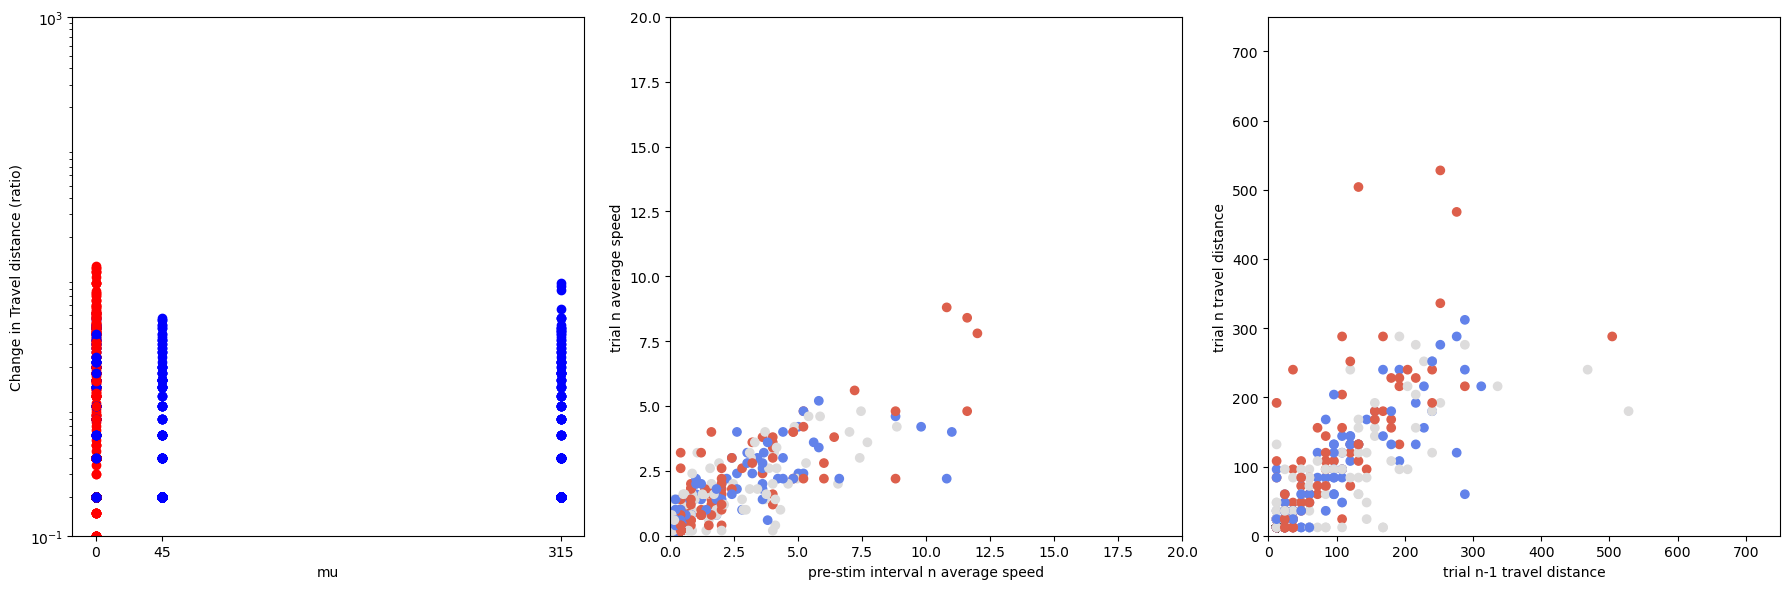

In [35]:
# def plot_travel_distance_set(df_all,analysis_methods,parameter_name,y_axis_lim=[0.1,1000]):
parameter_name='mu'
y_axis_lim=[0.1,1000]
COL = MplColorHelper(colormap_name, 0, 8)
fig, (ax1, ax2,ax3) = plt.subplots(
nrows=1, ncols=3, figsize=(18, 6), tight_layout=True
)
colour_code=analysis_methods.get("graph_colour_code")
if parameter_name=='order':
    ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_ylim([y_axis_lim[0],y_axis_lim[1]])
ax1.set(
    yticks=[y_axis_lim[0], y_axis_lim[1]],
    ylabel="Change in Travel distance (ratio)",
    xticks=sorted(df_all[0][parameter_name].unique()),
    xlabel=parameter_name,
)
ax2.set_ylim(0,20)
ax2.set_xlim(0,20)
ax2.set(
    ylabel="trial n average speed",
    xlabel="pre-stim interval n average speed",
)
ax3.set_ylim(0,750)
ax3.set_xlim(0,750)
ax3.set(
    ylabel="trial n travel distance",
    xlabel="trial n-1 travel distance",
)
for id in np.arange(len(df_all)):
#for this_dir,this_vr in dir_dict:
    df=df_all[id]

    #set some thresholds to remove bad tracking 
    df.loc[(df["distTotal"]<10.0) | (df["loss"]> 0.05), "distTotal"] = np.nan
    if df.iloc[0]["VR"].startswith('VR1'):
        this_color=colour_code[0]
    elif df.iloc[0]["VR"].startswith('VR2'):
        this_color=colour_code[1]
    elif df.iloc[0]["VR"].startswith('VR3'):
        this_color=colour_code[2]
    else:
        this_color=colour_code[3]
    #ax1.scatter(df.iloc[1::2][parameter_name], df[1::2]["distTotal"]/df[::2]["distTotal"],c=this_color)
    #ax2.scatter(df[::2]["distTotal"],df.iloc[1::2]["distTotal"],c=this_color,alpha=df.iloc[1::2]['alpha'])
    # below is a quick check when pre-stim interval is 5 min long and isi is 1 min and when there is a post-stim interval
    ax1.scatter(df.iloc[::2][parameter_name], df.iloc[::2]["distTotal"]/df.iloc[::2]["duration"],c=colour_code[0])
    ax1.scatter(df.iloc[1::2][parameter_name], df.iloc[1::2]["distTotal"]/df.iloc[1::2]["duration"],c=colour_code[1])
    #ax1.scatter(df.iloc[3::2][parameter_name], df[3::2]["distTotal"]/df[2:-1:2]["distTotal"],c=this_color)
    #ax1.scatter(df.iloc[1][parameter_name], df.iloc[1]["distTotal"]/df.iloc[0]["distTotal"]*5,c=this_color)
    # ax2.scatter(df.iloc[0]["distTotal"]/5,df.iloc[1]["distTotal"],c=this_color,alpha=df.iloc[1]['alpha']) 
    # ax2.scatter(df[2:-1:2]["distTotal"],df.iloc[3::2]["distTotal"],c=this_color,alpha=df.iloc[3::2]['alpha'])
    # ax3.scatter(df.iloc[1:-2:2]["distTotal"], df[3::2]["distTotal"],c=this_color,alpha=df.iloc[3::2]['alpha'])
    ##below are some commands to set samples from the same parameters the same colour
    #ax2.scatter(df.iloc[0]["distTotal"]/5,df.iloc[1]["distTotal"],c=np.array([COL.get_rgb(int(df.iloc[1]['alpha']*10))]))
    #print(df.iloc[::2]["distTotal"].shape,df.iloc[1::2]["distTotal"].shape)
    #print(np.array([COL.get_rgb(int(df.iloc[1::2]['alpha']*10))]))
    #test=df_all[0][1::2]['alpha'].values*10
    alpha=df['alpha']*10
    alpha=alpha.astype('int')
    #print("test")
    ax2.scatter(df.iloc[::2]["distTotal"]/df.iloc[::2]["duration"],df.iloc[1::2]["distTotal"]/df.iloc[1::2]["duration"],c=COL.get_rgb(alpha[1::2]))
    #ax.grid(True)
    #scatter.colourbar
    ax3.scatter(df.iloc[1:-2:2]["distTotal"],df.iloc[3::2]["distTotal"],c=COL.get_rgb(alpha[3::2]))

    # legend1 = scatter.legend(*scatter.legend_elements(),loc="upper right", title="Direction")
    # scatter.add_artist(legend1)
    #ax2.set_title('different colour means data from different direction')
    #ax3.scatter(df.iloc[1:-2:2]["distTotal"], df[3::2]["distTotal"],c=np.array([COL.get_rgb(int(df.iloc[1]['alpha']*10))]))
plt.show()

In [36]:
#Firstly, concatenate every animal's dataframe into a big table and then sort them based on conditions.
if len(dfxy_all)>0:
    dfxy_con = pd.concat(dfxy_all)
if len(df_all)>0:
    df_con = pd.concat(df_all)
good_tracking=df_con['loss'] < 0.05

mu:0
8


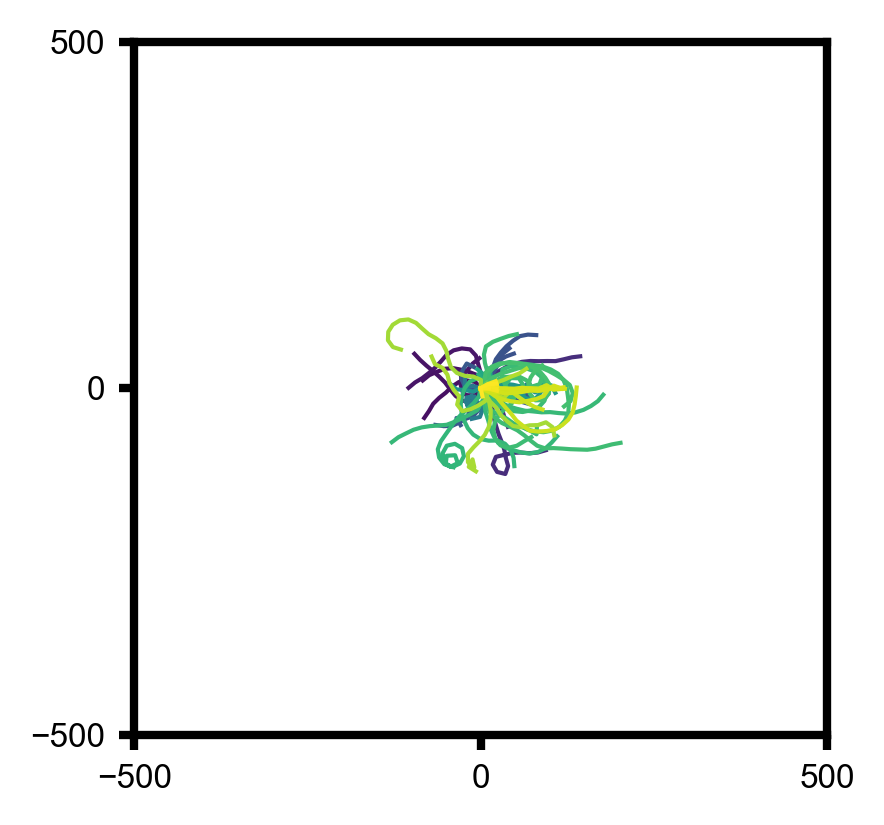

mu:45
8


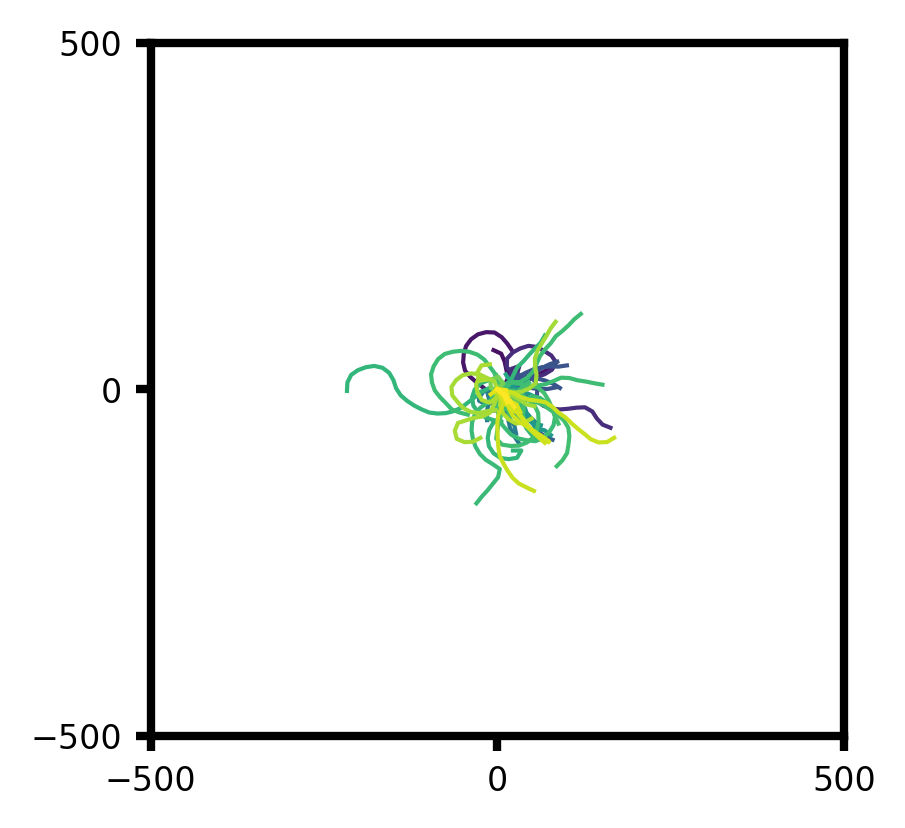

mu:315
8


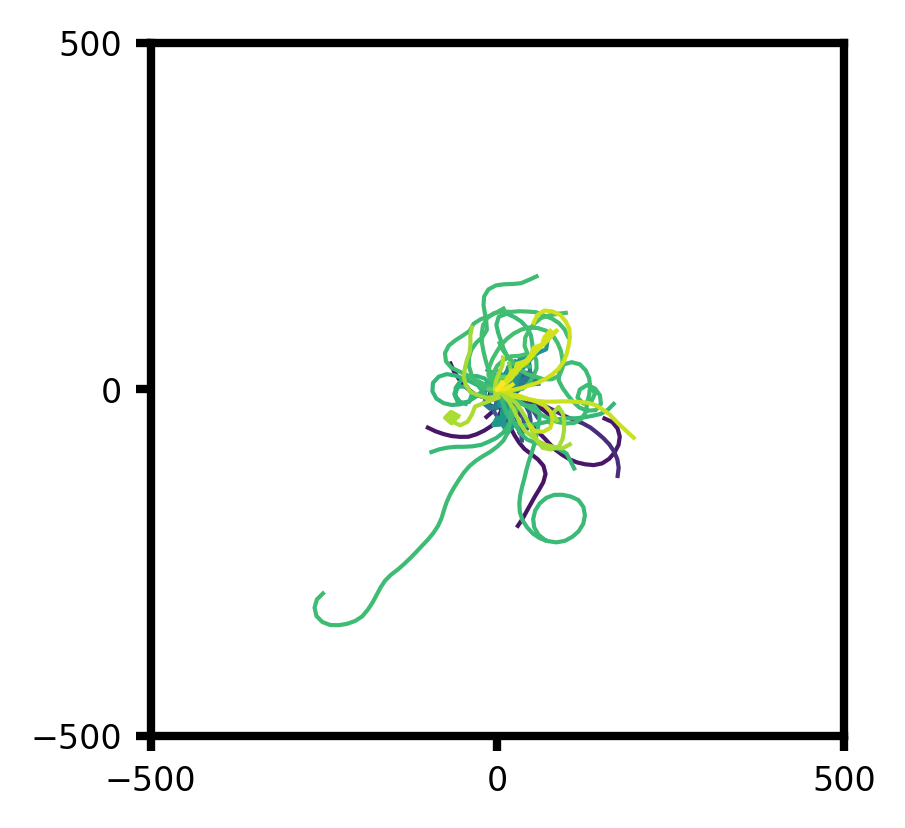

In [43]:
#plotting trajectory
if analysis_methods.get("experiment_name")=="choice":
    stim_or_isi=dfxy_con['initial_distance']
elif analysis_methods.get("experiment_name")=="swarm":
    stim_or_isi=dfxy_con['density']
df_stim=dfxy_con.loc[(dfxy_con['VR'].isin(df_con["VR"][good_tracking])) & (stim_or_isi>0)]
for key, grp in df_stim.groupby(parameter_name):
    print(f"{parameter_name}:{key}")
    plot_sercantrajec(grp,key,parameter_name,500)

In [ ]:
#set condition dfxy_con['density']>0 to select stimulus trial
#xy_lim at around 2000 is good for trial lasts around 4 or 5 min
#xy_lim at around 500 is good for trial lasts around 1 min
df_stim=dfxy_con.loc[(dfxy_con['VR'].isin(df_con["VR"][good_tracking])) & (stim_or_isi>0)]
for key, grp in df_stim.groupby(parameter_name):
    print(f"{parameter_name}:{key}")
    plot_sercantrajec(grp,key,parameter_name,500)

In [ ]:
#set condition dfxy_con['density']==0 to select ISI
#xy_lim at around 2000 is good for trial lasts around 4 or 5 min
#xy_lim at around 500 is good for trial lasts around 1 min
df_isi=dfxy_con.loc[(dfxy_con['VR'].isin(df_con["VR"][good_tracking])) & (stim_or_isi==0)]
for key, grp in df_isi.groupby(parameter_name):
    print(f"{parameter_name}:{key}")
    plot_sercantrajec(grp,key,parameter_name,500)

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


mu:0


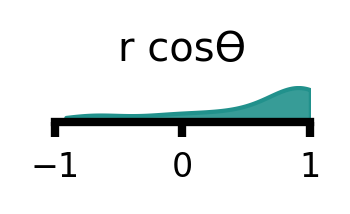

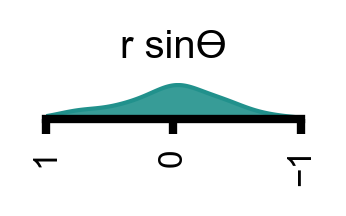

mu:45


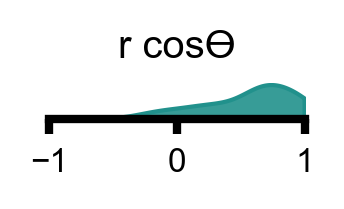

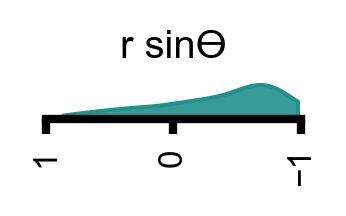

mu:315


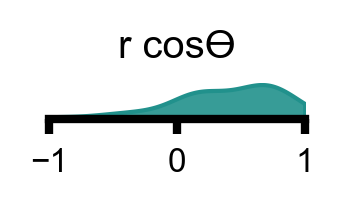

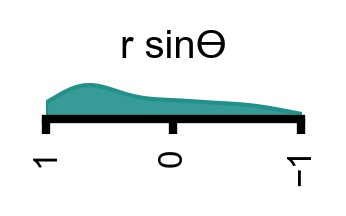

mu:0


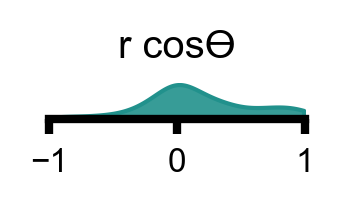

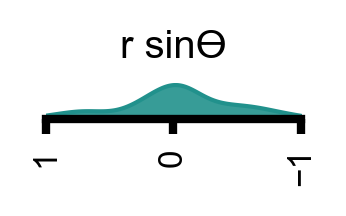

In [40]:
#plot mean angle
if analysis_methods.get("experiment_name")=="choice":
    stim_or_isi=df_con['initial_distance']
elif analysis_methods.get("experiment_name")=="swarm":
    stim_or_isi=df_con['density']
df_stim=df_con[stim_or_isi>0]
for key, grp in df_stim.groupby(parameter_name):
    print(f"{parameter_name}:{key}")
    plot_sercansincos(grp,key,parameter_name)
df_isi=df_con[stim_or_isi==0]
for key, grp in df_isi.groupby(parameter_name):
    print(f"{parameter_name}:{key}")
    plot_sercansincos(grp,key,parameter_name)

Session 2.3.2: plot individual animal's response.

In [ ]:
dir_iterator=[]
if 'vr_no' in locals():
    dir_iterator=zip(dir_list,vr_no)
elif 'dir_dict' in locals():
    dir_iterator=dir_dict 
    parameter_name='order'
    for this_dir,this_vr in dir_iterator:
        this_color=colour_code[this_vr]
        locust_pattern = f"VR{this_vr}*score.h5"
        found_result = find_file(Path(this_dir), locust_pattern)        
        df = pd.read_hdf(found_result)
        df.loc[(df["distTotal"]<5) | (df["loss"]> 0.05), "distTotal"] = np.nan
        df_stim=df[df['density']>0]
        df_isi=df[df['density']==0]
        for key, grp in df_stim.groupby('order'):
            print(f"order:{key}")
            plot_sercantrajec(grp,key,parameter_name,2000)
            plot_sercansincos(grp,key,parameter_name)
else:
    print("should plot every animal in a for-loop, and a nested-for loop. This section will igonre which VR setup they come from")


extra session: Analyse data with multi-engines

In [ ]:
##this cell start the multi-engines. Make sure to run only once
import time
import ipyparallel as ipp
def show_clusters():
    clusters = ipp.ClusterManager().load_clusters() 
    print("{:15} {:^10} {}".format("cluster_id", "state", "cluster_file")) 
    for c in clusters:
        cd = clusters[c].to_dict()
        cluster_id = cd['cluster']['cluster_id']
        controller_state = cd['controller']['state']['state']
        cluster_file = getattr(clusters[c], '_trait_values')['cluster_file']
        print("{:15} {:^10} {}".format(cluster_id, controller_state, cluster_file))
    return cluster_id

cluster = ipp.Cluster(n=6)
await cluster.start_cluster()
cluster_neuropc=show_clusters()

In [ ]:
##input cluster_id from previous cell
rc = ipp.Client(cluster_id=cluster_neuropc)

# Create a DirectView for parallel execution
dview = rc.direct_view()

# Define a function for parallel processing
def process_directory(this_dir, analysis_methods):
    from pathlib import Path
    import sys
    current_working_directory = Path.cwd()
    parent_dir = current_working_directory.resolve().parents[0]
    sys.path.insert(0, str(parent_dir) + "\\utilities")
    from locustvr_converter import preprocess_matrex_data
    preprocess_matrex_data(this_dir,analysis_methods)

# Define analysis_methods

# Use parallel execution to process directories
dview.map_sync(process_directory, dir_list, [analysis_methods] * len(dir_list))

In [ ]:
rc.shutdown()